<a href="https://colab.research.google.com/github/jmontano1987/pdg/blob/main/Proyecto_de_Grado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto de Grado**

**Título:** Modelo para la detección de Noticias Falsas en tweets con formato de texto en el contexto político colombiano para las elecciones del año 2022.

**Integrantes:**
* Jesus Eduardo Flores Q.
* Juan Gabriel Montaño M.

#**Instalaciones**

In [1]:
!pip install tweepy
!pip3 install tqdm
!pip install spacy
!pip install matplotlib
!pip install wordcloud
!spacy download es_core_news_sm
!pip install unidecode
!pip install --upgrade openpyxl
!pip install wget
!pip install scikit-plot

     |████████████████████████████████| 16.2 MB 5.1 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=08285d127d9ec7e80cc716ca36ca10bc20680870c35347c2845149da76bf33d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-vr8rq_3z/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
     |████████████████████████████████| 235 kB 5.0 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=8df725b2146c7d5204a039b990ab2f8f98c015326f9f2fe6e162e56f0aa18bed
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


#**Librerias**

In [1]:
import io
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import string
import tweepy
from tqdm.notebook import tqdm as tqdm_notebook
from dateutil import tz
from datetime import datetime 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#**Funciones**

In [2]:
#Funcion que convierte el formato de la fecha del tweet en hora GMT -5 Colombia
def convert_date(str_date):
  str_format_date = '%Y-%m-%d %H:%M:%S' 
  from_zone = tz.gettz('UTC')
  to_zone = tz.gettz('America/Bogota')
  date_convert = datetime.strptime(str(str_date), str_format_date)
  date_convert = date_convert.replace(tzinfo=from_zone)
  date_convert = date_convert.astimezone(to_zone)
  date_convert = datetime.strftime(date_convert,'%d/%m/%Y %H:%M:%S')
  return date_convert

In [3]:
#Funcion para obtener los tweets de un usuario especifio de twitter
def get_tweets(api,username):
  tweets={}
  for tweet in tqdm_notebook(tweepy.Cursor(api.user_timeline, screen_name = username).items()):
      tweets[tweet.id]= {
          'text': tweet.text,
          'created_at': convert_date(tweet.created_at),
          'author_name': tweet.user.name,
          'author_handler': str(tweet.user.screen_name),
          'user_description': tweet.user.description,
          'user_location': tweet.user.location,
          'user_followers_count': tweet.user.followers_count,
          'user_created_at': convert_date(tweet.user.created_at),
          'user_following_count': tweet.user.friends_count,
          'user_verified': tweet.user.verified,
          'lang': tweet.lang,
          'tweet_hashtags': tweet.entities['hashtags'],
          'mention_names': ["@" + d['screen_name'] for d in tweet.entities['user_mentions'] if 'screen_name' in d],
          'mention_ids': [d['id'] for d in tweet.entities['user_mentions'] if 'id' in d],
          'n_retweets': tweet.retweet_count,
          'n_favorites': tweet.favorite_count,
          'is_retweet': hasattr(tweet, 'retweeted_status')
      }
  df_tweets = pd.DataFrame.from_dict(tweets, orient='index')
  df_tweets['id'] = df_tweets.index
  return df_tweets

In [4]:
def remove_newlines_tabs(text):
 # Remover saltos de linea
  formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
  return formatted_text

In [5]:
def remove_whitespace(text):
  # Remover espacios en blanco
    pattern = re.compile(r'\s+') 
    without_whitespace = re.sub(pattern, ' ', text)
    text = without_whitespace.replace(')', ') ')
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").lstrip()
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").rstrip()
    return text    

In [6]:
# removerlos al final
def remueveEspaciosFinales(x):
  if type(x)==str:
    return x.rstrip()
  else:
    return x

In [7]:
def remueveEspaciosIniciales(x):
  if type(x)==str:
    return x.lstrip()
  else:
    return x

In [8]:
def accented_characters_removal(text):
  # Remover tildes
    text = unidecode.unidecode(text)
    return text

In [9]:
def remove_special_characters(text):
    # Remover caracteres especiales
    return text.translate(str.maketrans('','',string.punctuation))


In [10]:
def lower_text(text):
    # Convertir mayusculas a minusculas
    text = text.lower()
    return text

In [11]:
stoplist = stopwords.words('spanish') 
stoplist = set(stoplist)
def remove_stopwords(text):
    # Remover stop words
    # repr() function actually gives the precise information about the string
    text = repr(text)
    # Texto sin stopwords
    nostopwords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convertir lista en tipo String
    words_string = ' '.join(nostopwords)   
    return words_string

In [12]:
nlp = spacy.load('es_core_news_sm')
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [13]:
def remove_links(text): 
    # Remover urls 
    text=re.sub('https://','',text)
    text=re.sub('opr-littps://','',text)
    return text

In [14]:
def remove_numbers(text):
    # Remover numeros
    formatted_text = re.sub(r"[0-9]+", ' ', text)
    formatted_text= re.sub(r"NUMBER", ' ', text)
    formatted_text= re.sub(r"number", ' ', text)
    return formatted_text

In [15]:
def text_preprocessing(text, accented_chars=True, newlines_tabs=True, extra_whitespace=True,lowercase=True,characters_specials=True,stop_words=True,lemmatization = True,links=True,numbers_remove=True):
      
    if newlines_tabs == True:  # Remover saltos de linea
        data = remove_newlines_tabs(text)

    if links == True: #remove links
        data = remove_links(data)
    
    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)
        
    if accented_chars == True: # Remover tildes
        data = accented_characters_removal(data)    
    
    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)

    if lowercase == True: # Convertir mayusculas a minusculas
        data = lower_text(data)

    if numbers_remove == True: # Remover caracteres especiales
        data = remove_numbers(data)

    if stop_words == True: # Remover stopwords
        data = remove_stopwords(data)

    if lemmatization == True: # Lematizacion
       data = lemmatizer(data)

    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)

    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)
    
       
    return data

In [16]:
def change_categories(campo):
    if campo=='True' or campo=='Noticia Real':
        return 'Noticia Real'
    else:
        return 'Noticia Falsa'

#**Twitter**

Credenciales Consumo API

In [17]:
# API Keys para autenticacion
api_key = "UcZ9gR5yMV4MlKTFaSwhC1aNX" 
api_secret = "R5BjKcmHan6MGaX98UMhytQfLiZI7TLl9AATGtixJLwmAU2DFR"
access_token = "1452452402070794241-rKitK0leSslMs9XoXEDBTxOwplOGGU"
access_token_secret = "lBAxKokr4Hkg3DxvaUMTWkAqU0E9O5KfZCmJoPulnfSRn"

In [18]:
# Autorización para consumo API
auth = tweepy.OAuthHandler(api_key, api_secret) 
# Acceso al API
auth.set_access_token(access_token, access_token_secret) 
# Instancia para llamar a la API 
api = tweepy.API(auth, wait_on_rate_limit=True) 

In [19]:
#Obtener Tweets de cuenta
df_tweets=get_tweets(api,"juanmontan0")

0it [00:00, ?it/s]

In [20]:
df_tweets.head()

,text,created_at,author_name,author_handler,user_description,user_location,user_followers_count,user_created_at,user_following_count,user_verified,lang,tweet_hashtags,mention_names,mention_ids,n_retweets,n_favorites,is_retweet,id
1489046418262310918,prueba twitter 2022,02/02/2022 20:21:45,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1489046418262310918
1488863725675290625,prueba proyecto grado miercoles,02/02/2022 08:15:48,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1488863725675290625
1488713846130941958,Prueba proyecto de grado febrero 2022,01/02/2022 22:20:14,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1488713846130941958
1488526595614773253,Esto es una prueba para la tesis de grado,01/02/2022 09:56:10,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1488526595614773253
1488522887137046543,prueba 3,01/02/2022 09:41:26,juanmontan0,juanmontan0,,,0,24/10/2021 20:50:17,8,False,es,[],[],[],0,0,False,1488522887137046543


#**Cargar Corpus**

In [21]:
# Los archivos de corpus se pueden cargar localmente mediante el menu de la izquierda (load)
from google.colab import files
uploaded = files.upload()

Saving Corpus_Noticias_Falsas.xlsx to Corpus_Noticias_Falsas.xlsx


In [22]:
# Los archivos de corpus se pueden cargar localmente mediante el menu de la izquierda (load)
from google.colab import files
uploaded = files.upload()

Saving train.xlsx to train.xlsx


In [23]:
df=pd.read_excel("Corpus_Noticias_Falsas.xlsx")
df2=pd.read_excel("train.xlsx")

In [24]:
df

,ID,Categoria,Tema,Origen,Titulo,Texto,Enlace
0,1,Noticia Real,Politico,El tiempo,Duque dice que Eln se adjudicó atentado y busc...,El presidente Iván Duque condenó fuertemente e...,https://www.eltiempo.com/politica/gobierno/eln...
1,2,Noticia Real,Politico,El espectador,"Gustavo Petro se reunirá con Pedro Sánchez, pr...","Gustavo Petro se reunirá con Pedro Sánchez, pr...",https://www.elespectador.com/politica/?utm_sou...
2,3,Noticia Real,Politico,El tiempo,Marta Lucía Ramírez se queja por servicio en e...,Marta Lucía Ramírez se queja por servicio en e...,https://www.eltiempo.com/politica/gobierno/mar...
3,4,Noticia Real,Politico,El espectador,"Elecciones de 2022 requieren mayor cuidado, po...","Elecciones de 2022 requieren mayor cuidado, po...",https://www.elespectador.com/politica/eleccion...
4,5,Noticia Real,Politico,El Nuevo Siglo,Procuraduría citó a mandatarios por fiestas en...,ANTE LA expansión de la variante ómicron en el...,https://www.elnuevosiglo.com.co/articulos/01-0...
...,...,...,...,...,...,...,...
492,496,Noticia Real,Politico,El colombiano,Destruyen valla del Partido Comunes en Puerto ...,Los pasacalles de la campaña de Comunes en Pue...,https://www.elcolombiano.com/colombia/politica...
493,497,Noticia Real,Politico,El colombiano,"“Cuando la corrupción llega, hay que buscar re...",En medio de uno de los momentos más difíciles ...,https://www.elcolombiano.com/colombia/politica...
494,498,Noticia Real,Politico,El colombiano,Este sábado empieza la inscripción de candidat...,Entre el sábado 29 de enero y el viernes 11 de...,https://www.elcolombiano.com/colombia/politica...
495,499,Noticia Real,Politico,El colombiano,Corte “no vio a profundidad lo que se ha logra...,El presidente Iván Duque respondió a la decisi...,https://www.elcolombiano.com/colombia/respuest...


In [25]:
df=df[['Categoria','Texto']] # Corpus creado por Eduardo Flores y Juan Montano
df

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
492,Noticia Real,Los pasacalles de la campaña de Comunes en Pue...
493,Noticia Real,En medio de uno de los momentos más difíciles ...
494,Noticia Real,Entre el sábado 29 de enero y el viernes 11 de...
495,Noticia Real,El presidente Iván Duque respondió a la decisi...


In [26]:
df.value_counts(df['Categoria'])

Categoria
Noticia Real     260
Noticia Falsa    237
dtype: int64

In [27]:
## seleccionar las dos columans de trabajo
df2=df2[['Category','Text']] # Corpus Posadas-Duran
df2

,Category,Text
0,Fake,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR..."
1,Fake,"La palabra ""haiga"", aceptada por la RAE La Rea..."
2,Fake,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...
3,True,UNAM capacitará a maestros para aprobar prueba...
4,Fake,Alerta: pretenden aprobar libros escolares con...
...,...,...
671,Fake,Madonna será la nueva imagen del Chocolate Abu...
672,True,"Filtran material íntimo de Zelina Vega, luchad..."
673,Fake,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Fake,TV Azteca anuncia que cambiará su nombre por u...


In [28]:
df2=df2.rename(columns={'Category':'Categoria', 'Text':'Texto'})

In [29]:
df2.value_counts('Categoria')

Categoria
Fake    338
True    338
dtype: int64

In [30]:
df_base=pd.concat([df,df2], axis=0, ignore_index=False)
df_base

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
671,Fake,Madonna será la nueva imagen del Chocolate Abu...
672,True,"Filtran material íntimo de Zelina Vega, luchad..."
673,Fake,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Fake,TV Azteca anuncia que cambiará su nombre por u...


In [31]:
df_base.Categoria.value_counts()

Fake             338
True             338
Noticia Real     260
Noticia Falsa    237
Name: Categoria, dtype: int64

In [32]:
df_base

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
671,Fake,Madonna será la nueva imagen del Chocolate Abu...
672,True,"Filtran material íntimo de Zelina Vega, luchad..."
673,Fake,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Fake,TV Azteca anuncia que cambiará su nombre por u...


In [33]:
df_base["Categoria"]=df_base["Categoria"].apply(change_categories)
df_base

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
671,Noticia Falsa,Madonna será la nueva imagen del Chocolate Abu...
672,Noticia Real,"Filtran material íntimo de Zelina Vega, luchad..."
673,Noticia Falsa,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Noticia Falsa,TV Azteca anuncia que cambiará su nombre por u...


In [34]:
df_base.Categoria.value_counts()

Noticia Real     598
Noticia Falsa    575
Name: Categoria, dtype: int64

In [38]:
df_merge=df_base

In [36]:
df_merge

,Categoria,Texto
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr..."
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po..."
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...
...,...,...
671,Noticia Falsa,Madonna será la nueva imagen del Chocolate Abu...
672,Noticia Real,"Filtran material íntimo de Zelina Vega, luchad..."
673,Noticia Falsa,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674,Noticia Falsa,TV Azteca anuncia que cambiará su nombre por u...


#**Preprocesamiento**

* Convertir Mayusculas a minusculas
* Remover links
* Remover números
* Remover signos de puntuación
* Remover tildes
* Remover comillas
* Remover retornos y lineas nuevas
* Remover StopWords
* Lematización

In [39]:
List_News = df_merge['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in List_News:
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_merge['Processed_Text'] = Complete_Content

In [40]:
df_merge.Texto.iloc[500]

'UNAM capacitará a maestros para aprobar prueba Pisa\nLa máxima casa de estudios y la SEP firmaron cinco convenios para que las facultades de Ciencias y Química, así como el Instituto de Matemáticas de enseñen a los profesores estrategias para impartir estas disciplinas a los alumnos de preescolar, primaria, secundaria\nLa Universidad Nacional Autónoma de México (UNAM) capacitará a profesores de educación obligatoria en matemáticas, ciencias y lectura en la enseñanza de estas materias en las escuelas públicas ante la necesidad de mejorar los resultados de México en las pruebas internacionales de aprovechamiento escolar, como PISA.\n Durante la firma de un convenio general y cuatro específicos de colaboración entre la Universidad Nacional y la Secretaría de Educación Pública (SEP), el rector Enrique Graue Wiechers señaló que uno de los objetivos de estos instrumentos será que las facultades de Ciencias y Química, así como el Instituto de Matemáticas de la máxima casa de estudios colabor

In [41]:
df_merge.Processed_Text.iloc[500]

' unam capacitar maestro aprobar probar pisar maxima casar estudio sep firmar cincar convenio facultad ciencia quimica asi instituto matematicas ensenar profesor estrategia impartir disciplinar alumno preescolar primario secundario universidad nacional autonoma mexico unam capacitar profesor educacion obligatorio matematicas ciencia lectura ensenanza materia escuela publicar necesidad mejorar resultar mexico prueba internacional aprovechamiento escolar pisar firmar convenio general cuatro especificos colaboracion universidad nacional secretario educacion publicar sep rector enrique graue wiechers senalo objetivo instrumento sera facultad ciencia quimica asi instituto matematicas maxima casar estudio colaborar dependencia federal ofrecer curso capacitacion maestro mexicano '

In [42]:
real_news = df_merge[df_merge['Categoria'] == 'Noticia Real']
real_news

,Categoria,Texto,Processed_Text
0,Noticia Real,El presidente Iván Duque condenó fuertemente e...,el presidente ivan duque condenar fuertemente...
1,Noticia Real,"Gustavo Petro se reunirá con Pedro Sánchez, pr...",gustavo petro reunira pedro sanchez president...
2,Noticia Real,Marta Lucía Ramírez se queja por servicio en e...,marta lucio ramirez quejar servicio call cent...
3,Noticia Real,"Elecciones de 2022 requieren mayor cuidado, po...",elección 2022 requerir mayor cuidar menos inf...
4,Noticia Real,ANTE LA expansión de la variante ómicron en el...,ante expansion variante omicron territorio na...
...,...,...,...
662,Noticia Real,CHICHARITO 'ENCIENDE' EL INSTAGRAM DE YUYA\nEl...,chicharito encender instagram yuya atacante m...
665,Noticia Real,Elena Poniatowska: 'AMLO será un presidente mu...,elena poniatowska amlo sera presidente cercan...
667,Noticia Real,"Donald Trump, el hombre que «amaba» a las muje...",donald trump hombre amar mujer mas bello plan...
670,Noticia Real,Globos de Oro *NUMBER*: estos son los ganadore...,globo orar ganador primero premio postweinste...


In [43]:
fake_news = df_merge[df_merge['Categoria'] == 'Noticia Falsa']
fake_news

,Categoria,Texto,Processed_Text
32,Noticia Falsa,#ÚLTIMA_HORA Le ordenaré a los empresarios de ...,ultimahora ordenar empresario colombia descon...
41,Noticia Falsa,La plandemia solo fue creada para causar miedo...,lo plandemia solo crear causar miedo sometimi...
42,Noticia Falsa,Cuarentena estricta en Bogotá este jueves 30 d...,cuarentena estricto bogota jueves 30 diciembr...
43,Noticia Falsa,Esta Noche a partir de las 11:00 pm nadie podr...,este noche partir 1100 pm nadie pudrir callar...
44,Noticia Falsa,"CORONA VIRUS EN BUGA ""Invito a los bugueños a ...",coronar virus buga invitar buguenos mantener ...
...,...,...,...
669,Noticia Falsa,"Maradona totalmente drogado confiesa ""Me quier...",maradona totalmente drogar confesar querer ga...
671,Noticia Falsa,Madonna será la nueva imagen del Chocolate Abu...,madonna sera nuevo imagen chocolate abuelita ...
673,Noticia Falsa,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...,cbs planear gran hermanar casar blanco trump ...
674,Noticia Falsa,TV Azteca anuncia que cambiará su nombre por u...,tv azteca anunciar cambiar nombrar mas nacion...


# **Analitica Descriptiva**

## Word Cloud Fake News

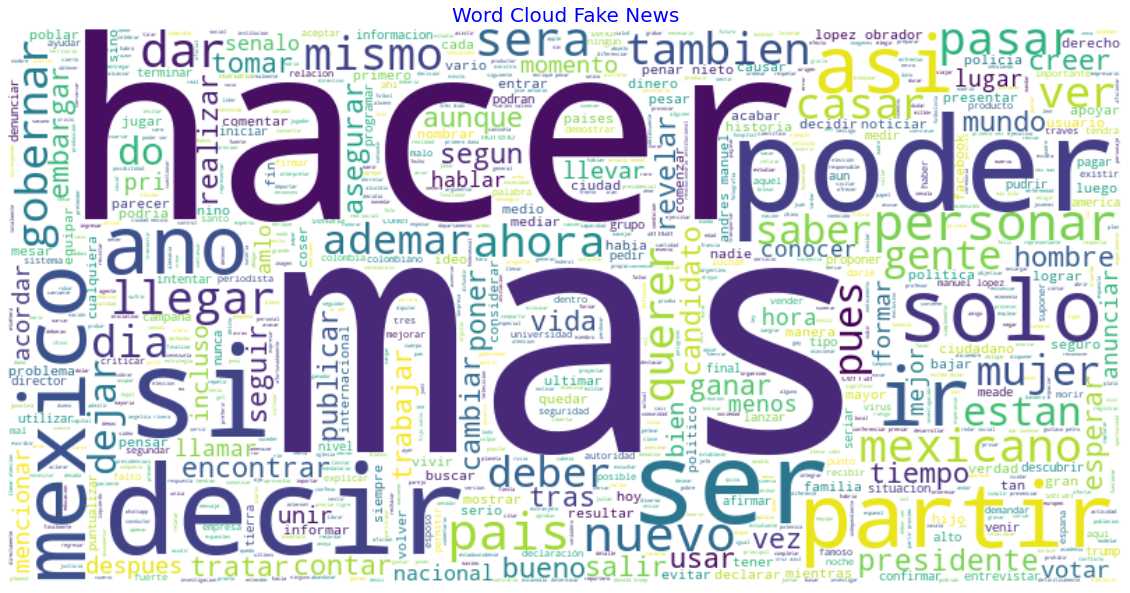

In [44]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Cloud Real News

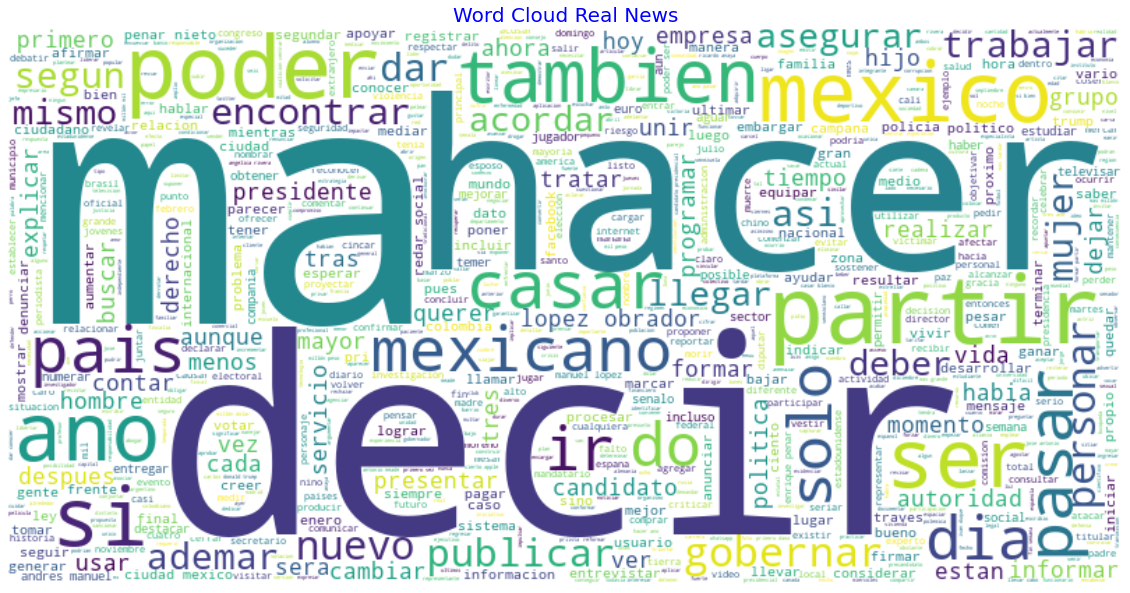

In [45]:
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Modelamiento**

## Label coding

In [46]:
category_codes = {
     'Noticia Real': 0,
    'Noticia Falsa': 1
}

In [47]:
df_merge['Codigo'] = df_merge['Categoria']
df_merge = df_merge.replace({'Codigo':category_codes})

## Train-Test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_merge['Processed_Text'], 
                                                    df_merge['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

## Text representation

In [113]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [114]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train)
features_test = tfidf.transform(X_test)
labels_train = y_train
labels_test = y_test
print(features_train.shape)
print(features_test.shape)

(938, 300)
(235, 300)


# Nueva sección

## Modelos de clasificación

Metricas de evaluación

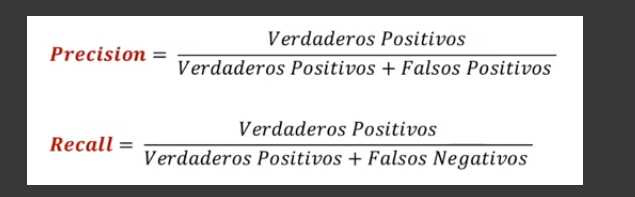

### Randomized Search Cross Validation

In [102]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


#### Random Search

In [103]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
The best hyperparameters from Random Search are:
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.7825189099150761
CPU times: user 5min 31s, sys: 1.25 s, total: 5min 32s
Wall time: 5min 33s


In [104]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.

clf = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=1, max_features='auto', max_depth=80, bootstrap=True)

clf.fit(features_train, labels_train)

RandomForestClassifier(max_depth=80, n_estimators=1000)

Text(39.49999999999999, 0.5, 'Predicted')

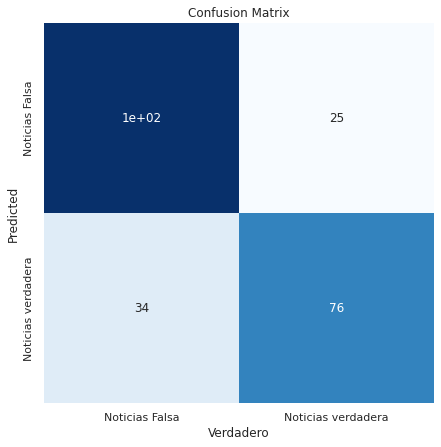

In [54]:
clf_predict = clf.predict(features_test)
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, clf_predict)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [55]:
print(accuracy_score(labels_test, clf_predict))

0.7489361702127659


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


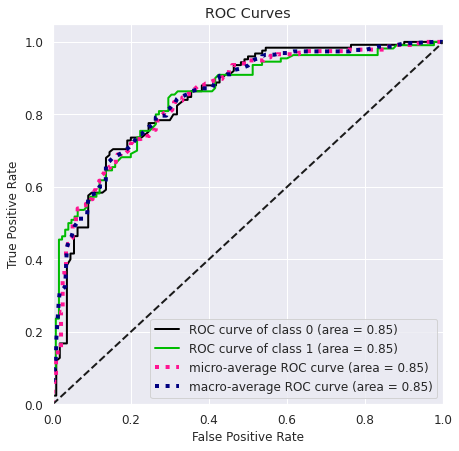

In [56]:
clf_predict_proba = clf.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, clf_predict_proba)
plt.show()

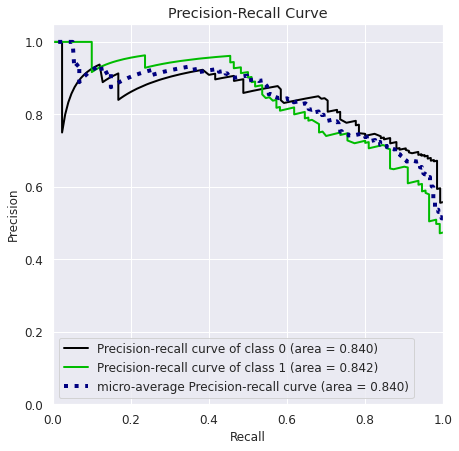

In [57]:
skplt.metrics.plot_precision_recall(labels_test,clf_predict_proba)

#### Grid Search Cross Validation

In [58]:
%%time

# Create the parameter grid based on the results of random search 
bootstrap = [False]
max_depth = [50, 100, 150]
max_features = ['auto']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [1000]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

# Create a base model
rfc = RandomForestClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
The best hyperparameters from Grid Search are:
{'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1000}

The mean accuracy of a model with these hyperparameters is:
0.7688172043010754
CPU times: user 4min 52s, sys: 962 ms, total: 4min 53s
Wall time: 4min 54s


In [59]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000, random_state=8)

#### Fit and performance

In [60]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000, random_state=8)

In [61]:
# tomamos el best model para realizar la predicción.
rfc_pred = best_rfc.predict(features_test)

#### Test accuracy

In [62]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, rfc_pred))

The test accuracy is: 
0.7574468085106383


#### Confusion Matrix

Text(39.49999999999999, 0.5, 'Predicted')

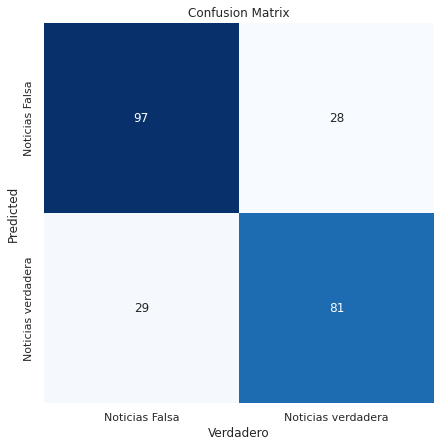

In [63]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, rfc_pred)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


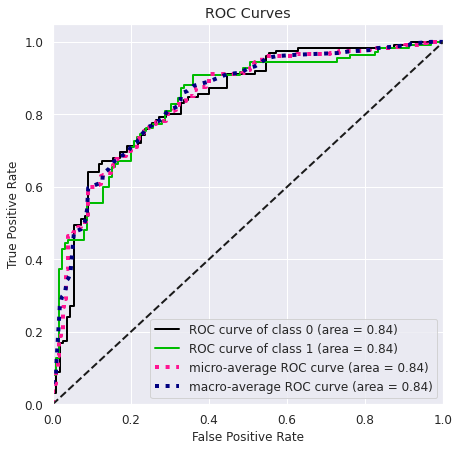

In [64]:
rfc_pred_proba= best_rfc.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,rfc_pred_proba)
plt.show()

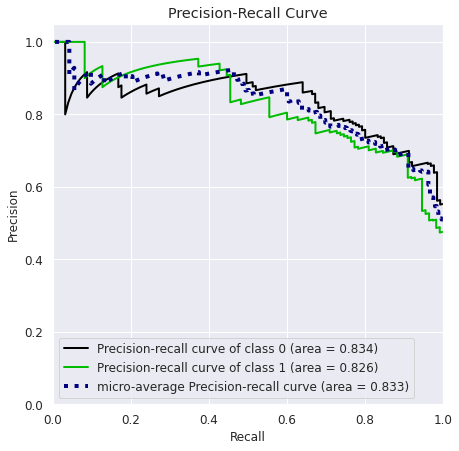

In [65]:
skplt.metrics.plot_precision_recall(labels_test,rfc_pred_proba)

## Naive Bayes

In [67]:
# fit the training dataset on the NB classifier
Naive = MultinomialNB()
Naive.fit(features_train ,labels_train)
# predict the labels on validation dataset
predictions_NB = Naive.predict(features_test)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, labels_test)*100)

Naive Bayes Accuracy Score ->  71.91489361702128


Text(39.49999999999999, 0.5, 'Predicted')

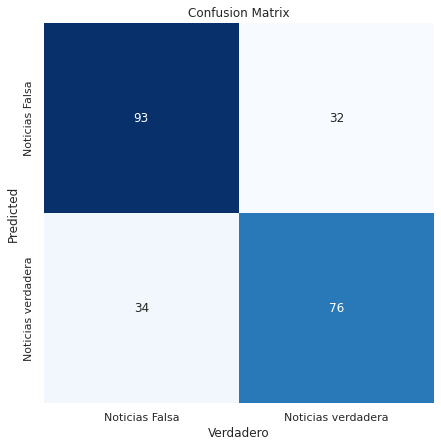

In [68]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_NB)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


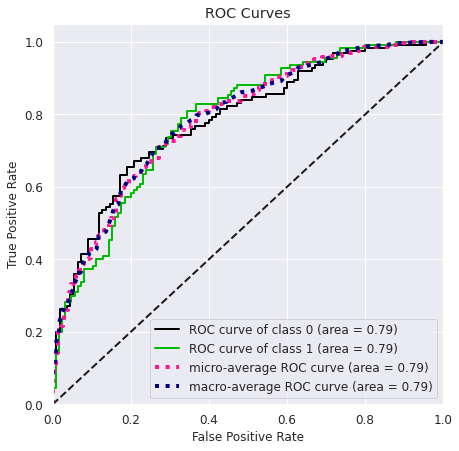

In [69]:
naive_pred_proba= Naive.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,naive_pred_proba)
plt.show()

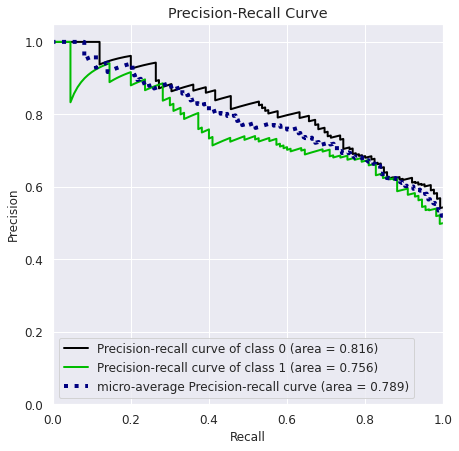

In [70]:
skplt.metrics.plot_precision_recall(labels_test,naive_pred_proba)

## SVC

In [71]:
# SVM
model = SVC()
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)
grid.fit(features_train,labels_train)
print("best params",grid.best_params_)

predictions_SVM = grid.predict(features_test)
print(classification_report(labels_test,predictions_SVM))
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, labels_test)*100)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .......................C=1, gamma=1, k

In [72]:
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, labels_test)*100)

SVM Accuracy Score ->  78.29787234042553


Text(39.49999999999999, 0.5, 'Predicted')

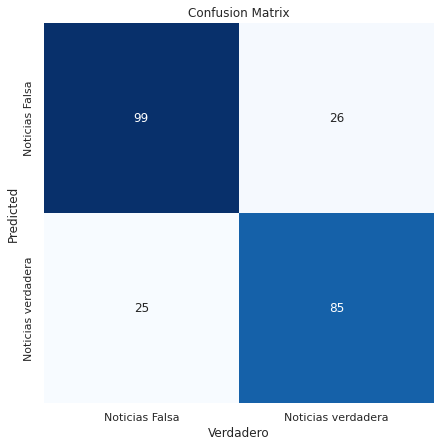

In [73]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_SVM)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


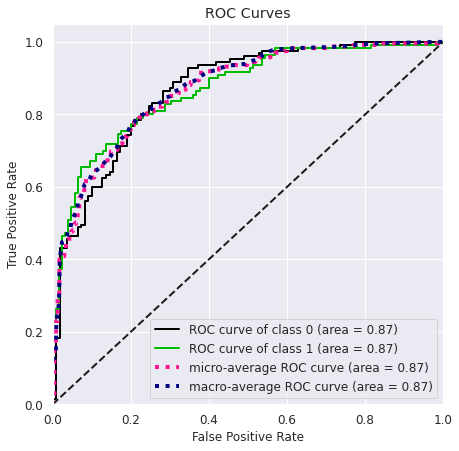

In [74]:
svc_rbf=SVC(kernel='rbf',C=1, gamma=1, probability=True)
svc_model=svc_rbf.fit(features_train, labels_train)
predict_rbf=svc_model.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_rbf)
plt.show()

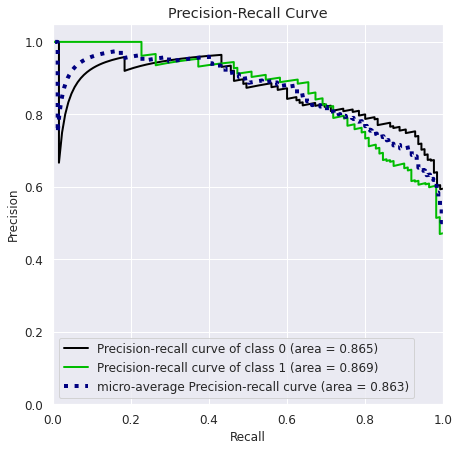

In [75]:
skplt.metrics.plot_precision_recall(labels_test,predict_rbf)

## Logistic Regression

In [76]:
clasifier=LogisticRegression(random_state=0, class_weight='balanced')
model=clasifier.fit(features_train,labels_train)

In [77]:
y_predict=model.predict(features_test)

In [78]:
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_predict, labels_test)*100)

Logistic Regression Accuracy Score ->  75.74468085106383


Text(39.49999999999999, 0.5, 'Predicted')

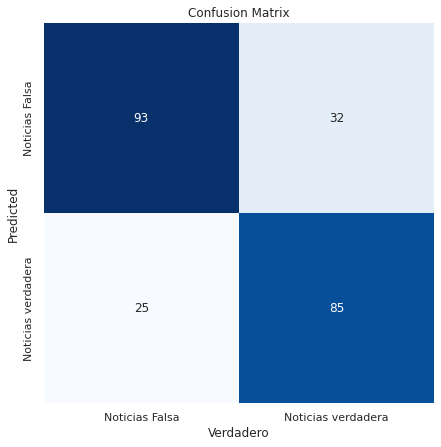

In [79]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, y_predict)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


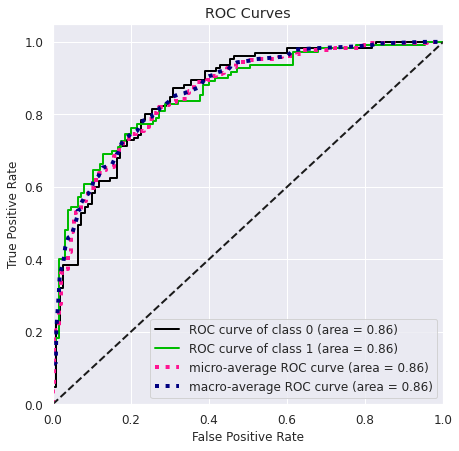

In [80]:
y_pred_proba= model.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

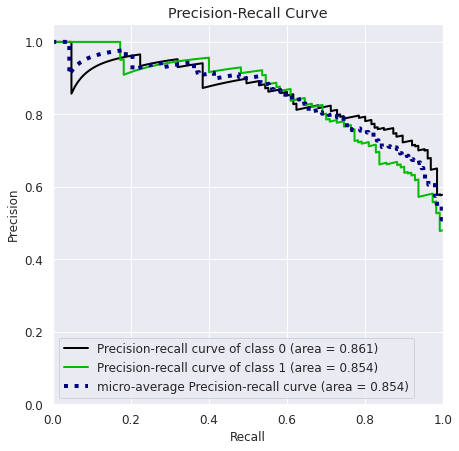

In [81]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

In [145]:
import pickle
with open(r'naive.pkl','wb') as model_pkl:
    pickle.dump(Naive, model_pkl, protocol=2)

In [146]:
model_prueba = pickle.load(open('naive.pkl', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


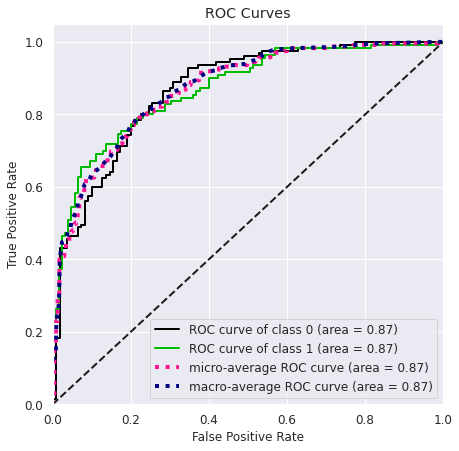

In [88]:
predictions_SVM2=model_prueba.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predictions_SVM2)
plt.show()



Text(39.49999999999999, 0.5, 'Predicted')

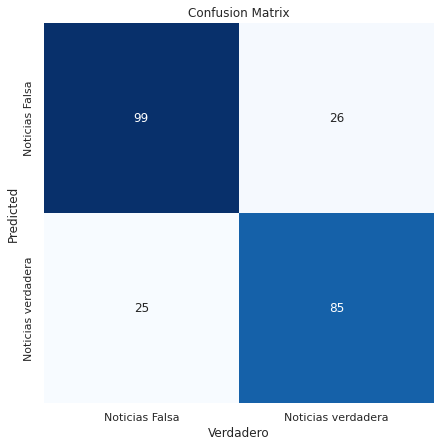

In [135]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_SVM2)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [117]:
Processed_Text = text_preprocessing("En la tarde de este lunes, 14 de febrero, una motobomba explotó cerca a la estación de Policía de Caloto, en el departamento del Cauca.De acuerdo con las primeras hipótesis, el artefacto explosivo fue dejado al lado de la casa cural de ese municipio.La explosión causó graves daños estructurales en varias viviendas aledañas al sector, además de que generó pánico en los habitantes de este municipio.")

In [118]:
Processed_Text

' en tardar lunes 14 febrero motobomba explotar cercar estacion policia caloto departamento caucade acordar primero hipotesis artefacto explosivo dejar lado casar cural municipiola explosion causar grave danos estructural varios vivienda aledanas sector ademar generar panico habitante municipio '

In [149]:
def detection_fake_news_(news):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf.transform(input_data)
    prediction = model_prueba.predict(vectorized_input_data)
    if prediction==0:
      print ("La noticia que ingreso es real")
    else:
        print ("La noticia que ingreso es falsa")

In [150]:
detection_fake_news_(Processed_Text)

La noticia que ingreso es real


In [151]:
vec_file = 'vectorizer.pickle'
pickle.dump(tfidf, open(vec_file, 'wb'))